In [1]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
import harmonypy as hm
import scrublet as scr

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120, color_map='viridis')
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.1.0
cffi                1.14.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                2.10.0
harmonypy           NA
igraph              0.7.1
importlib_metadata  1.5.0
ipykernel           5.1.4
ipython_genutils    0.2.0
jedi                0.16.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.8.2
llvmlite            0.34.0
matplotlib          3.2.1
mkl                 2.3.0
mpl_toolkits        NA
natsort             7.1.1
numba               0.51.2
numexpr             2.7.2
numpy               1.19.2
packaging           20.9
pandas              1.1.5
parso               0.6.2
pexpect             4.8.

In [2]:
def DEG_table(adata):
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    markers = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
    return markers

In [3]:
def filtered_DEGs(adata, q_value = 1E-5, fold_change = 1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] >= fold_change)].loc[:,(i+'_n'):(i+'_l')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [4]:
def filtered_DEG_names(adata, q_value = 1E-5, fold_change = 1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] >= fold_change)].loc[:,(i+'_n')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [5]:
def filtered_down_reg_DEGs(adata, q_value = 1E-5, fold_change = -1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] <= fold_change)].loc[:,(i+'_n'):(i+'_l')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [6]:
def filtered_down_reg_DEG_names(adata, q_value = 1E-5, fold_change = -1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] <= fold_change)].loc[:,(i+'_n')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [7]:
adata_orig = sc.read_h5ad('./fish_ven_filtered_089042021.h5ad')

In [8]:
adata_orig

AnnData object with n_obs × n_vars = 7422 × 25107
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample', 'batch'
    var: 'gene_ids', 'feature_types'

In [9]:
adata = adata_orig.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy()


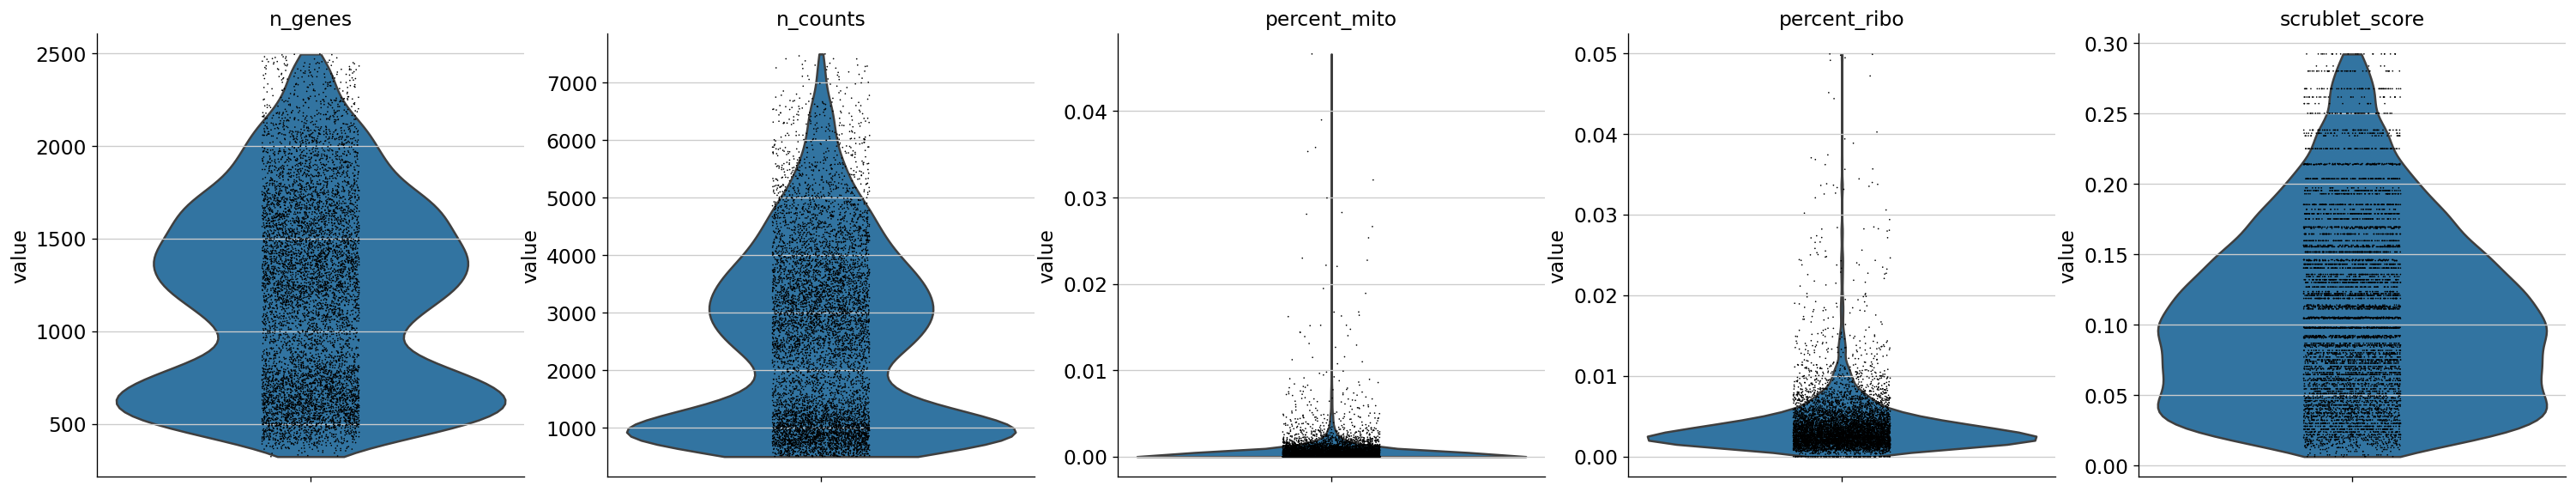

In [10]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito','percent_ribo', 'scrublet_score'],
             jitter=0.1, multi_panel=True)

In [11]:
sc.pp.highly_variable_genes(adata, flavor = 'seurat')
adata_hvg = adata[:, adata.var['highly_variable']]

In [12]:
sc.pp.scale(adata_hvg, max_value =10)

/rds/general/user/lb616/home/anaconda3/envs/scanpy2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
sc.tl.pca(adata_hvg, svd_solver='arpack', random_state = 1786)

In [14]:
# Here we do batch correction using harmony, it modifies the PCA space. 
# If you don't have any batches to correct for then this is not necessary. eg. sequence multiple regions from a single heart, you wouldn't want to batch correct as you would lose regional differences
# Here I use the .obs field 'Sample' as the batch groups to correct for.

pca = adata_hvg.obsm['X_pca']
batch = adata_hvg.obs['Sample']
meta_data = adata_hvg.obs

ho = hm.run_harmony(pca, meta_data, ['Sample'
                                    ], random_state=1718, epsilon_harmony = -float('Inf'), max_iter_kmeans = 10, tau=5)

res = pd.DataFrame(ho.Z_corr)
res=res.T
adata_hvg.obsm['X_pca'] = res.values

2021-07-01 11:42:32,612 - harmonypy - INFO - Iteration 1 of 10
2021-07-01 11:42:34,306 - harmonypy - INFO - Iteration 2 of 10
2021-07-01 11:42:36,037 - harmonypy - INFO - Iteration 3 of 10
2021-07-01 11:42:37,764 - harmonypy - INFO - Iteration 4 of 10
2021-07-01 11:42:39,440 - harmonypy - INFO - Iteration 5 of 10
2021-07-01 11:42:41,113 - harmonypy - INFO - Iteration 6 of 10
2021-07-01 11:42:42,812 - harmonypy - INFO - Iteration 7 of 10
2021-07-01 11:42:44,217 - harmonypy - INFO - Iteration 8 of 10
2021-07-01 11:42:45,489 - harmonypy - INFO - Iteration 9 of 10
2021-07-01 11:42:46,474 - harmonypy - INFO - Iteration 10 of 10
2021-07-01 11:42:47,463 - harmonypy - INFO - Stopped before convergence


In [15]:
sc.pp.neighbors(adata_hvg, random_state = 1786)
sc.tl.umap(adata_hvg, min_dist = 0.5, spread = 1, random_state = 1718)

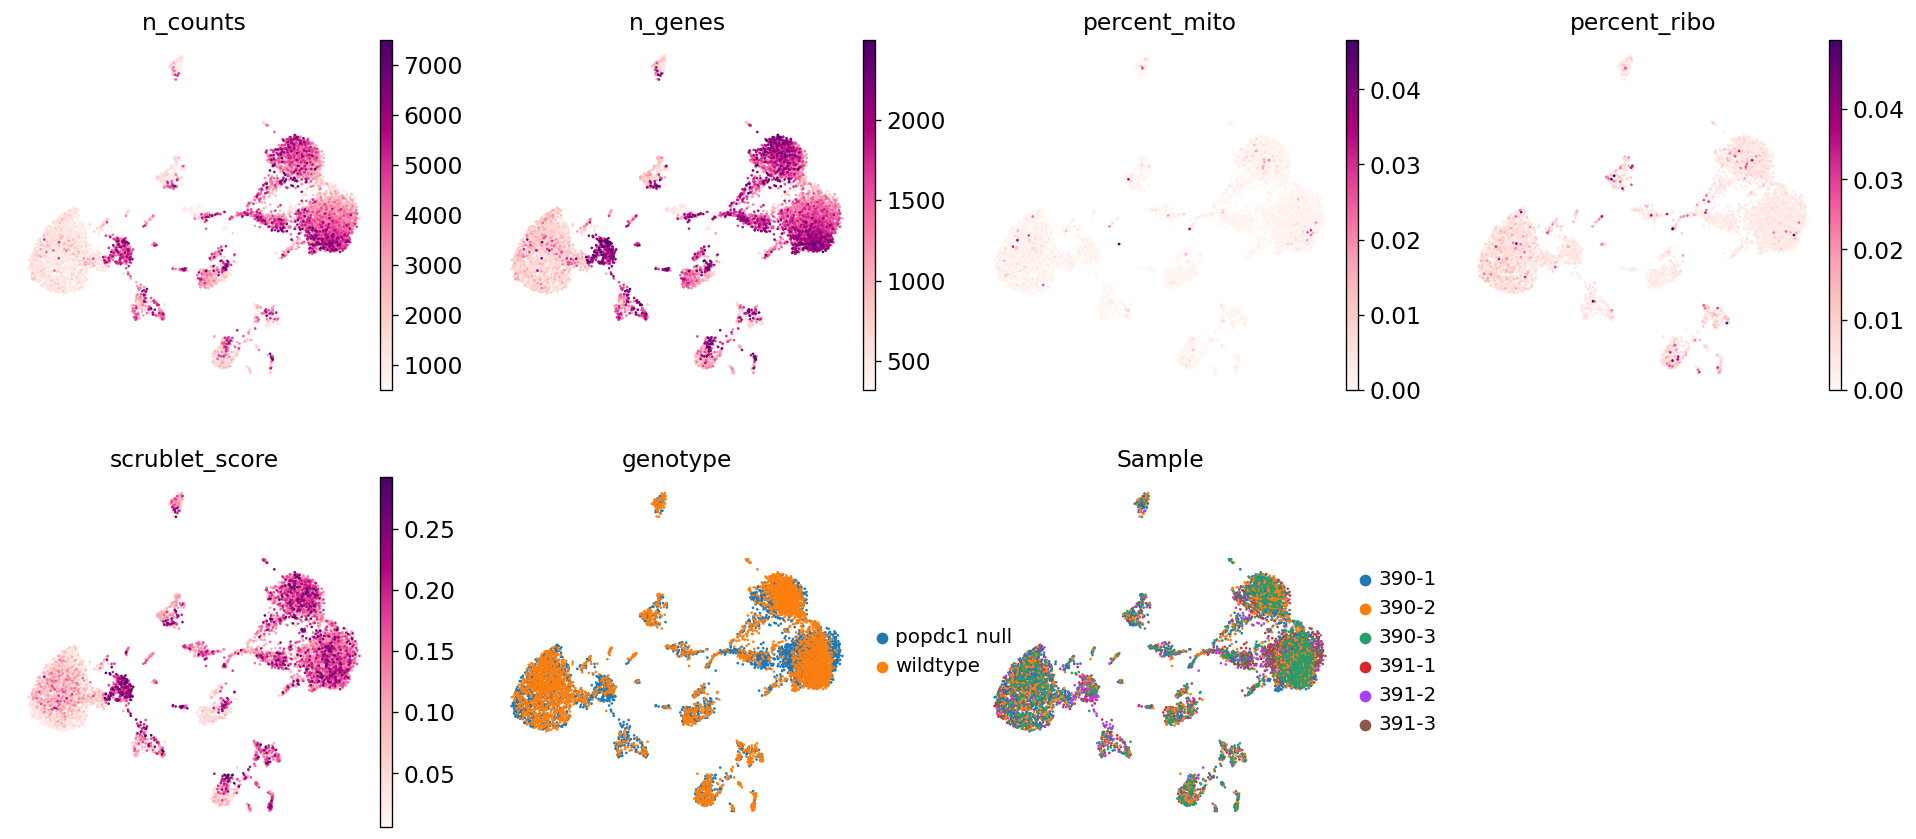

In [16]:
sc.pl.umap(adata_hvg, color = ['n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'scrublet_score', 'genotype','Sample'], size = 10, legend_fontsize = 12, frameon = False, color_map='RdPu'
          )

In [17]:
sc.tl.leiden(adata_hvg, resolution = 0.1, random_state = 1786, key_added = 'leiden_01')
sc.tl.leiden(adata_hvg, resolution = 0.11, random_state = 1786, key_added = 'leiden_011')
sc.tl.leiden(adata_hvg, resolution = 0.12, random_state = 1786, key_added = 'leiden_012')
sc.tl.leiden(adata_hvg, resolution = 0.13, random_state = 1786, key_added = 'leiden_013')
sc.tl.leiden(adata_hvg, resolution = 0.14, random_state = 1786, key_added = 'leiden_014')
sc.tl.leiden(adata_hvg, resolution = 0.15, random_state = 1786, key_added = 'leiden_015')
sc.tl.leiden(adata_hvg, resolution = 0.16, random_state = 1786, key_added = 'leiden_016')
sc.tl.leiden(adata_hvg, resolution = 0.17, random_state = 1786, key_added = 'leiden_017')
sc.tl.leiden(adata_hvg, resolution = 0.18, random_state = 1786, key_added = 'leiden_018')
sc.tl.leiden(adata_hvg, resolution = 0.19, random_state = 1786, key_added = 'leiden_019')

sc.tl.leiden(adata_hvg, resolution = 0.2, random_state = 1786, key_added = 'leiden_02')
sc.tl.leiden(adata_hvg, resolution = 0.21, random_state = 1786, key_added = 'leiden_021')
sc.tl.leiden(adata_hvg, resolution = 0.22, random_state = 1786, key_added = 'leiden_022')
sc.tl.leiden(adata_hvg, resolution = 0.23, random_state = 1786, key_added = 'leiden_023')
sc.tl.leiden(adata_hvg, resolution = 0.24, random_state = 1786, key_added = 'leiden_024')
sc.tl.leiden(adata_hvg, resolution = 0.25, random_state = 1786, key_added = 'leiden_025')
sc.tl.leiden(adata_hvg, resolution = 0.26, random_state = 1786, key_added = 'leiden_026')
sc.tl.leiden(adata_hvg, resolution = 0.27, random_state = 1786, key_added = 'leiden_027')
sc.tl.leiden(adata_hvg, resolution = 0.28, random_state = 1786, key_added = 'leiden_028')
sc.tl.leiden(adata_hvg, resolution = 0.29, random_state = 1786, key_added = 'leiden_029')

sc.tl.leiden(adata_hvg, resolution = 0.3, random_state = 1786, key_added = 'leiden_03')
sc.tl.leiden(adata_hvg, resolution = 0.31, random_state = 1786, key_added = 'leiden_031')
sc.tl.leiden(adata_hvg, resolution = 0.32, random_state = 1786, key_added = 'leiden_032')
sc.tl.leiden(adata_hvg, resolution = 0.33, random_state = 1786, key_added = 'leiden_033')
sc.tl.leiden(adata_hvg, resolution = 0.34, random_state = 1786, key_added = 'leiden_034')
sc.tl.leiden(adata_hvg, resolution = 0.35, random_state = 1786, key_added = 'leiden_035')
sc.tl.leiden(adata_hvg, resolution = 0.36, random_state = 1786, key_added = 'leiden_036')
sc.tl.leiden(adata_hvg, resolution = 0.37, random_state = 1786, key_added = 'leiden_037')
sc.tl.leiden(adata_hvg, resolution = 0.38, random_state = 1786, key_added = 'leiden_038')
sc.tl.leiden(adata_hvg, resolution = 0.39, random_state = 1786, key_added = 'leiden_039')

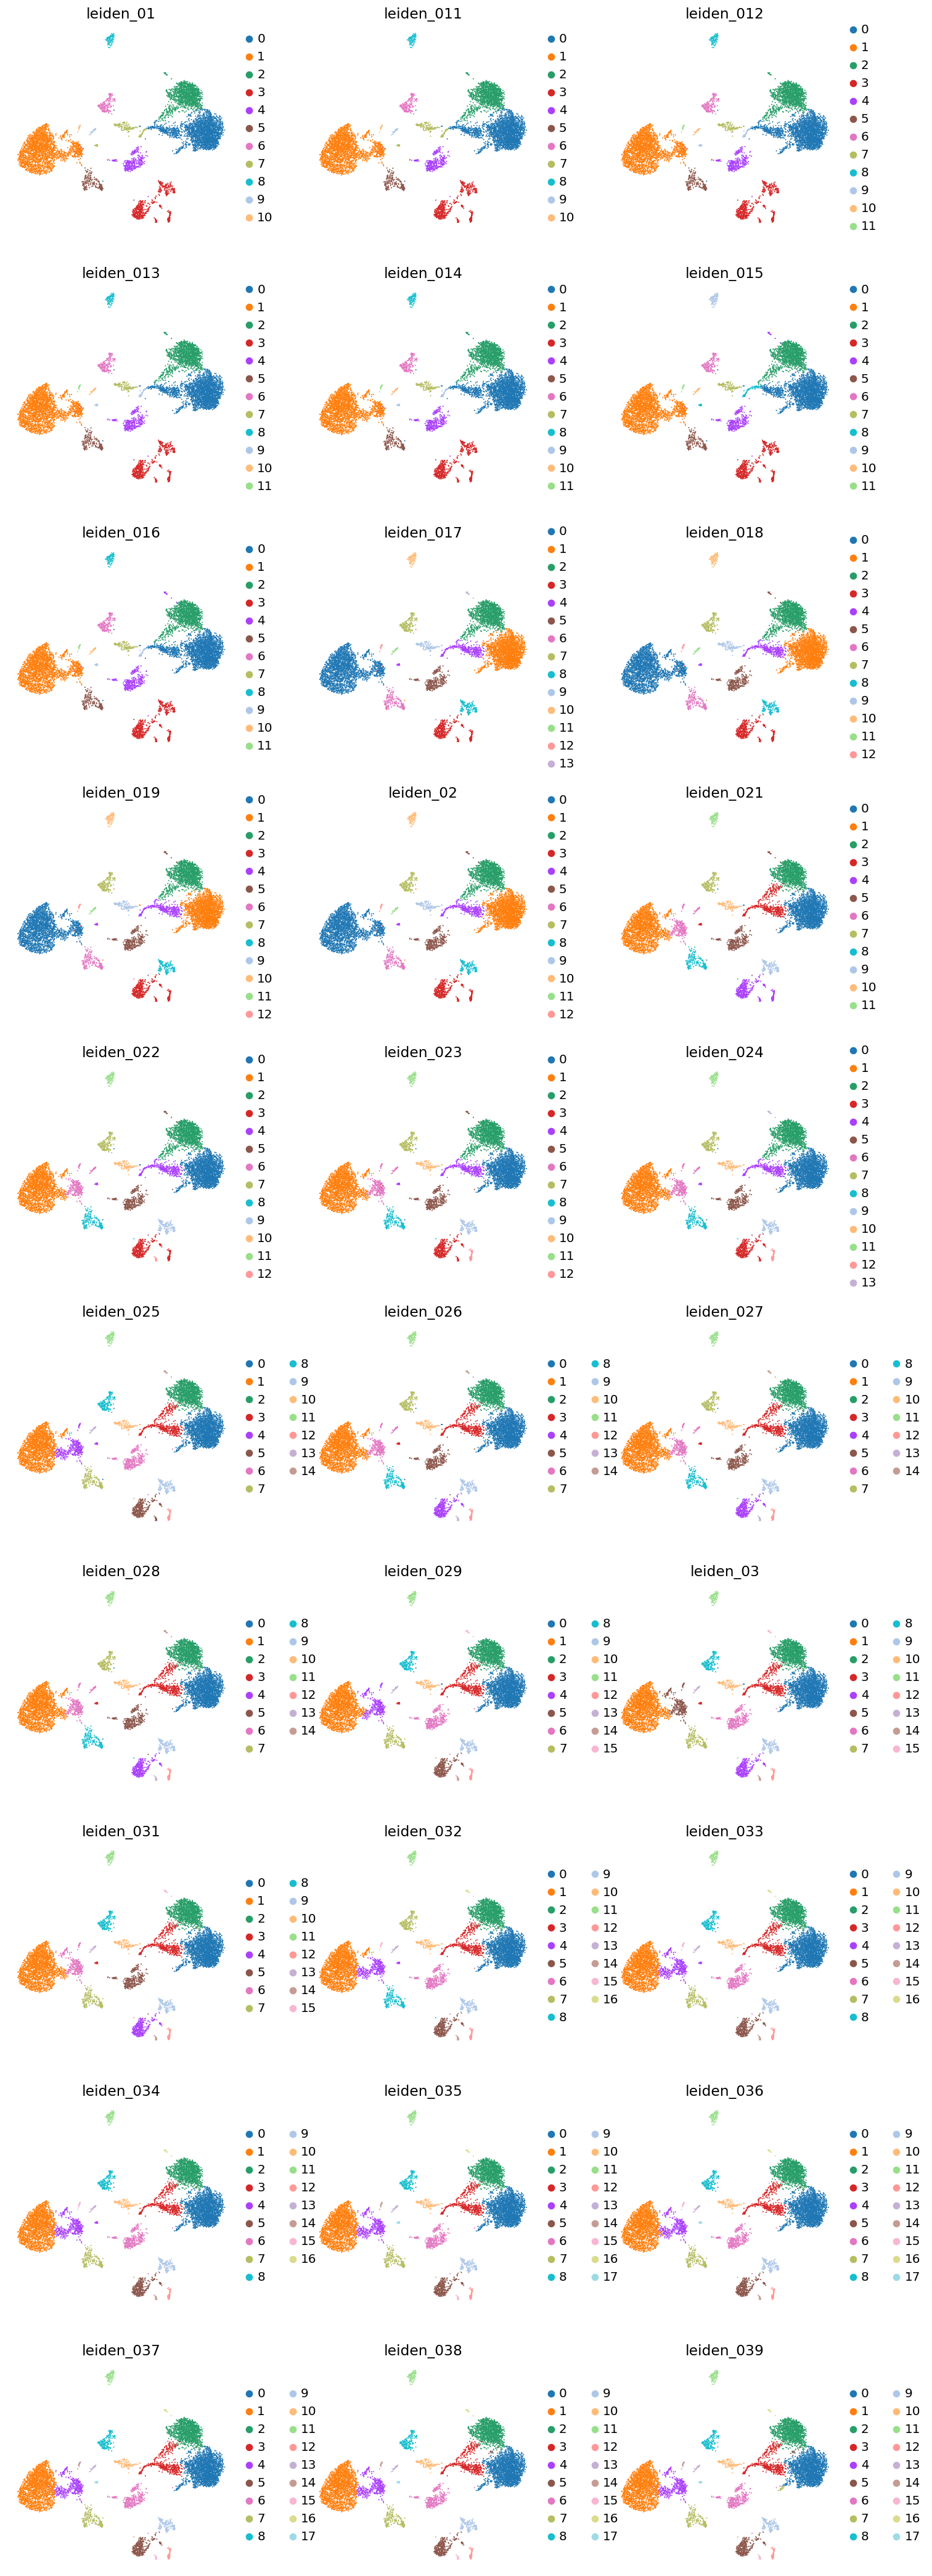

In [18]:
sc.pl.umap(adata_hvg, color = ['leiden_01', 'leiden_011','leiden_012','leiden_013','leiden_014','leiden_015','leiden_016','leiden_017','leiden_018','leiden_019',
                               'leiden_02', 'leiden_021','leiden_022','leiden_023','leiden_024','leiden_025','leiden_026','leiden_027','leiden_028','leiden_029',
                               'leiden_03', 'leiden_031','leiden_032','leiden_033','leiden_034','leiden_035','leiden_036','leiden_037','leiden_038','leiden_039']
           , size = 6, legend_fontsize = 12, frameon = False, ncols=3)

In [19]:
adata_hvg.obs['leiden'] = adata_hvg.obs.leiden_01

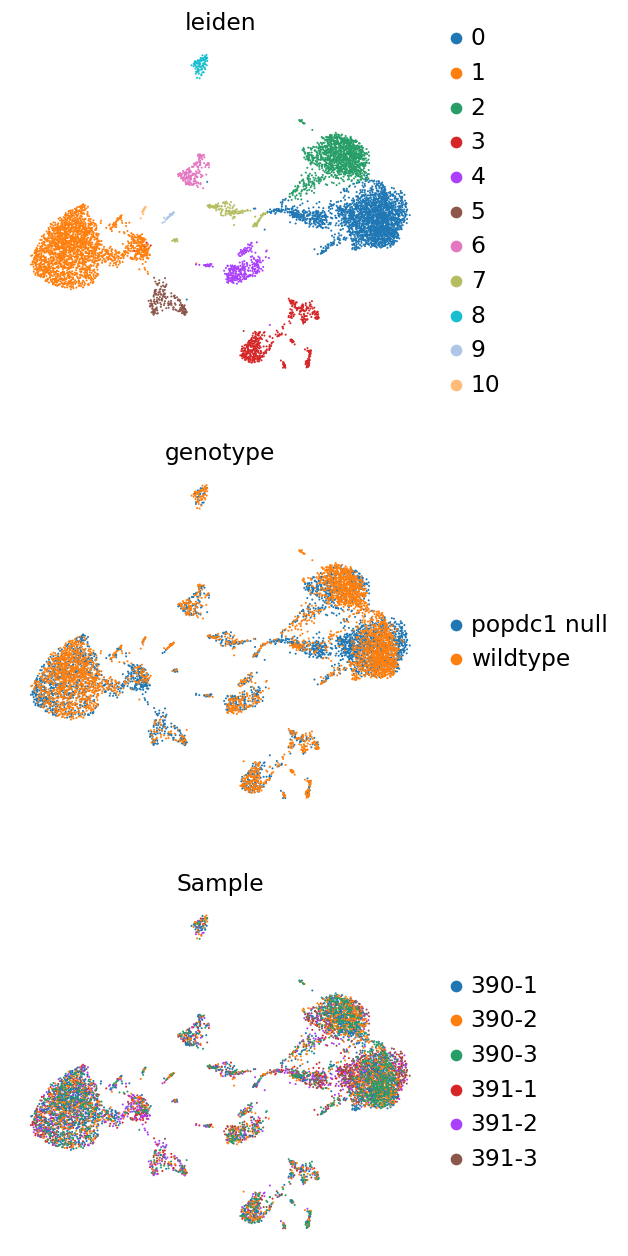

In [20]:
sc.pl.umap(adata_hvg, color = ['leiden', 'genotype', 'Sample' 
                              ], size = 6, legend_fontsize = 14, frameon = False, ncols=1)

In [21]:
# Crosstabs is a handy function for counting how many cells across .obs
pd.crosstab(adata_hvg.obs.genotype, adata_hvg.obs.leiden)

leiden,0,1,2,3,4,5,6,7,8,9,10
genotype,,,,,,,,,,,
popdc1 null,1217,977,422,208,144,123,82,94,25,7,3
wildtype,1167,1228,860,361,158,62,99,78,63,28,16


In [22]:
# Crosstabs is a handy function for counting how many cells across .obs
pd.crosstab(adata_hvg.obs.Sample, adata_hvg.obs.leiden)

leiden,0,1,2,3,4,5,6,7,8,9,10
Sample,,,,,,,,,,,
390-1,351,568,342,130,35,13,52,28,31,9,6
390-2,367,364,312,125,63,21,22,23,24,16,6
390-3,449,296,206,106,60,28,25,27,8,3,4
391-1,433,419,129,54,53,36,38,22,9,4,1
391-2,373,369,116,78,51,64,25,34,12,2,1
391-3,411,189,177,76,40,23,19,38,4,1,1


In [23]:
sc.tl.rank_genes_groups(adata_hvg, 'leiden'
                        , method = 'wilcoxon', use_raw = True)

In [24]:
markers_nuclei = DEG_table(adata_hvg)
markers_nuclei.head(10)

,0_n,0_p,0_l,1_n,1_p,1_l,2_n,2_p,2_l,3_n,...,7_l,8_n,8_p,8_l,9_n,9_p,9_l,10_n,10_p,10_l
0,scn5lab,0.0,4.182970,grb10a,0.0,6.970782,nbeaa,0.000000e+00,2.775859,ptprc,...,10.371014,pcdh1b,1.270554e-50,7.231215,flt4,1.570965e-17,10.365573,mcf2l2,0.000003,5.693504
1,cacna1g,0.0,4.241907,notch1b,0.0,4.940895,ldb3b,0.000000e+00,2.986407,si:dkey-262k9.4,...,4.462718,ebf1b,2.121438e-46,8.760954,cdh6,1.172372e-16,13.223375,pcdh1b,0.000005,5.875850
2,ryr2b,0.0,3.685208,agap1,0.0,3.309053,zfpm2a,1.007154e-306,2.122090,si:dkey-28k24.2-1,...,7.343401,myo1b,6.473303e-46,6.461975,ebf3a-1,8.360293e-16,6.016582,ebf1b,0.000005,7.269410
3,ank2b,0.0,3.296836,f8,0.0,7.029722,DAB2,4.162582e-288,3.146322,gnai2b,...,5.420742,tpm1,1.573524e-39,8.304470,mgat4b,1.622315e-14,5.434472,ptprb,0.000008,4.908812
4,crhr1,0.0,3.297297,spock3,0.0,6.860490,slco3a1,7.441562e-266,2.422142,gnao1a,...,9.001008,myh11a,2.694402e-37,6.816970,fnbp1b-1,1.917001e-12,3.226283,ldb2a,0.000064,6.074261
5,slc8a1a,0.0,3.714862,egfl7,0.0,6.728689,pcbp4,7.086610e-264,2.777122,celf2,...,3.959081,pde5ab,4.381316e-37,9.859148,stab1,9.760399e-12,6.702691,pknox2,0.000070,4.435206
6,mylk4b,0.0,3.839294,epas1b,0.0,6.851234,myh7ba,4.737150e-258,2.972554,gnai2a,...,3.224418,nck2b,1.195996e-36,5.835244,prkd3,1.991566e-10,4.041548,prex2,0.000074,4.321693
7,myh7l,0.0,3.826468,CU928117.1,0.0,5.019577,ryr1b,1.834165e-256,2.541238,rab44,...,3.998688,ebf3a,2.398050e-35,4.960098,rasip1,2.187836e-10,4.170278,ca16b,0.000123,8.067658
8,enox2,0.0,3.143811,srgap2,0.0,4.835447,plekha6,5.468031e-250,2.632509,cxcr4b,...,4.242347,col4a2,5.311526e-35,3.859374,rnf220a,3.233006e-10,6.896390,map4k2,0.000300,4.188455
9,angpt1,0.0,3.159064,gli3,0.0,5.444271,si:dkeyp-23e4.3,1.108943e-247,3.106943,elf1,...,3.704874,pdgfrb,1.996965e-34,7.982183,ZNF423,4.331284e-10,3.365483,spns2,0.000788,4.157712


In [25]:
sc.tl.dendrogram(adata_hvg, groupby='leiden')

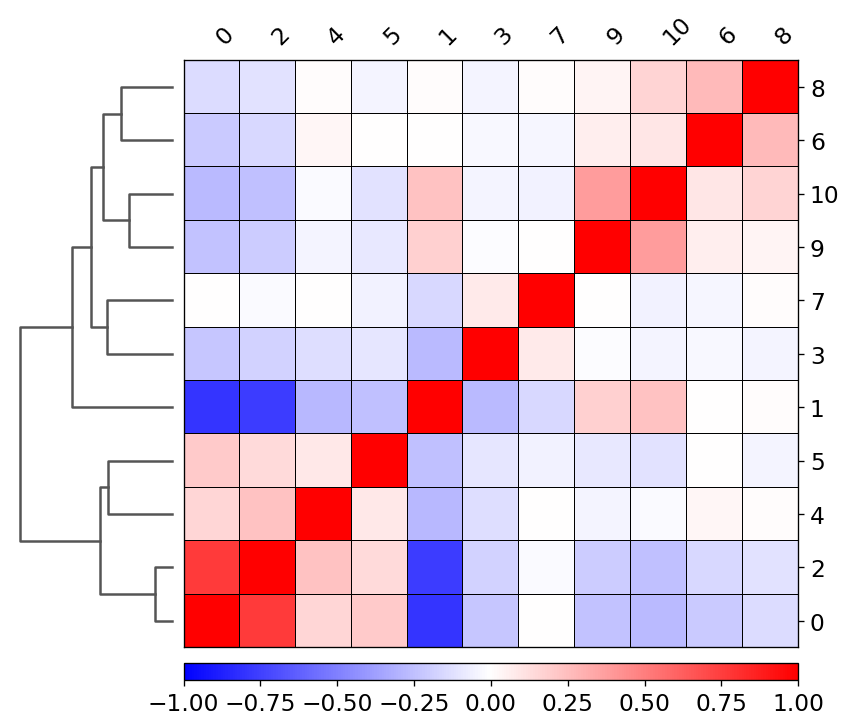

In [26]:
sc.pl.correlation_matrix(adata_hvg, groupby='leiden')

In [28]:
filtered_markers_nuclei = filtered_DEGs(adata_hvg, q_value = 1E-5, fold_change = 1)

In [29]:
filtered_markers_nuclei.head(20)

,0_n,0_p,0_l,1_n,1_p,1_l,2_n,2_p,2_l,3_n,...,7_l,8_n,8_p,8_l,9_n,9_p,9_l,10_n,10_p,10_l
0,scn5lab,0.0,4.182970,grb10a,0.0,6.970782,nbeaa,0.000000e+00,2.775859,ptprc,...,10.371014,pcdh1b,1.270554e-50,7.231215,flt4,1.570965e-17,10.365573,mcf2l2,0.000003,5.693504
1,cacna1g,0.0,4.241907,notch1b,0.0,4.940895,ldb3b,0.000000e+00,2.986407,si:dkey-262k9.4,...,4.462718,ebf1b,2.121438e-46,8.760954,cdh6,1.172372e-16,13.223375,pcdh1b,0.000005,5.875850
2,ryr2b,0.0,3.685208,agap1,0.0,3.309053,zfpm2a,1.007154e-306,2.122090,si:dkey-28k24.2-1,...,7.343401,myo1b,6.473303e-46,6.461975,ebf3a-1,8.360293e-16,6.016582,ebf1b,0.000005,7.269410
3,ank2b,0.0,3.296836,f8,0.0,7.029722,DAB2,4.162582e-288,3.146322,gnai2b,...,5.420742,tpm1,1.573524e-39,8.304470,mgat4b,1.622315e-14,5.434472,ptprb,0.000008,4.908812
4,crhr1,0.0,3.297297,spock3,0.0,6.860490,slco3a1,7.441562e-266,2.422142,gnao1a,...,9.001008,myh11a,2.694402e-37,6.816970,fnbp1b-1,1.917001e-12,3.226283,NaN,NaN,NaN
5,slc8a1a,0.0,3.714862,egfl7,0.0,6.728689,pcbp4,7.086610e-264,2.777122,celf2,...,3.959081,pde5ab,4.381316e-37,9.859148,stab1,9.760399e-12,6.702691,NaN,NaN,NaN
6,mylk4b,0.0,3.839294,epas1b,0.0,6.851234,myh7ba,4.737150e-258,2.972554,gnai2a,...,3.224418,nck2b,1.195996e-36,5.835244,prkd3,1.991566e-10,4.041548,NaN,NaN,NaN
7,myh7l,0.0,3.826468,CU928117.1,0.0,5.019577,ryr1b,1.834165e-256,2.541238,rab44,...,3.998688,ebf3a,2.398050e-35,4.960098,rasip1,2.187836e-10,4.170278,NaN,NaN,NaN
8,enox2,0.0,3.143811,srgap2,0.0,4.835447,plekha6,5.468031e-250,2.632509,cxcr4b,...,4.242347,col4a2,5.311526e-35,3.859374,rnf220a,3.233006e-10,6.896390,NaN,NaN,NaN
9,angpt1,0.0,3.159064,gli3,0.0,5.444271,si:dkeyp-23e4.3,1.108943e-247,3.106943,elf1,...,3.704874,pdgfrb,1.996965e-34,7.982183,ZNF423,4.331284e-10,3.365483,NaN,NaN,NaN


In [30]:
filtered_markers_names_nuclei = filtered_DEG_names(adata_hvg, q_value = 1E-5, fold_change = 1)
filtered_markers_names_nuclei.head(20)

,0_n,1_n,2_n,3_n,4_n,5_n,6_n,7_n,8_n,9_n,10_n
0,scn5lab,grb10a,nbeaa,ptprc,bcam,myh6,col6a3,itga2b,pcdh1b,flt4,mcf2l2
1,cacna1g,notch1b,ldb3b,si:dkey-262k9.4,tns1b,chrm2a,nfixb,zgc:66433,ebf1b,cdh6,pcdh1b
2,ryr2b,agap1,zfpm2a,si:dkey-28k24.2-1,pdlim5a,gnao1a,si:dkey-28k24.2-1,fn1b,myo1b,ebf3a-1,ebf1b
3,ank2b,f8,DAB2,gnai2b,fhod3b,rgs6,col5a1,myh11a,tpm1,mgat4b,ptprb
4,crhr1,spock3,slco3a1,gnao1a,sorbs1,fgf13a,egfra,mpl,myh11a,fnbp1b-1,NaN
5,slc8a1a,egfl7,pcbp4,celf2,daam1b,dpp6b,edil3a,lpp,pde5ab,stab1,NaN
6,mylk4b,epas1b,myh7ba,gnai2a,kif26ba,cacna1g,htra1b,spns2,nck2b,prkd3,NaN
7,myh7l,CU928117.1,ryr1b,rab44,phlda2,ahcyl2b,col5a3a,dgkg,ebf3a,rasip1,NaN
8,enox2,srgap2,plekha6,cxcr4b,agbl1,LRRTM4-1,adamtsl3,ano5b,col4a2,rnf220a,NaN
9,angpt1,gli3,si:dkeyp-23e4.3,elf1,plekha7a,si:dkey-112m2.1,bnc2,pbx1b,pdgfrb,ZNF423,NaN


In [31]:
adata_hvg.obs['leiden'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype='object')

In [32]:
adata_hvg.obs['leiden_annotation'] = adata_hvg.obs['leiden'].copy()

In [33]:
adata_hvg.obs['cell_type'] = adata_hvg.obs['leiden'].astype(str)
old_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
new_names = ['CM1', 'Endothelial Cells', 'CM2', 'Immune Cells', 'CM4', 'AV/ Ventricular Conduction Cells', 'Fibroblasts', 'Erythrocytes', 'Pericytes', 'Vasculature Cells', 'Endothelial Cells 2']
adata_hvg.obs['cell_type'] = adata_hvg.obs['cell_type'].map(dict(zip(old_names, new_names))).astype('category')